# PROJECT BRIEF

ADSS have just been awarded a contract by a government department (the Department of Environment) to help with the development of machine learning-based models for predicting atmospheric emissions (and pollution) from data gathered by various borough and county environment monitoring units.

Access the following URL:

https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory-2013

The web page describes the various types of data held for monitored atmospheric emissions for the year 2013. Note that ADSS will ultimately be working on datasets compiled over a 50-year period, but you will be focusing only on a single year (2013), in the first instance, when developing the ML models.

# DATASET OVERVIEW

## London Datastore

LAEI is a database of geographically referenced datasets of pollutant emissions in greater london

Estimates of key pollutants (NOx, PM10, PM2.5 and CO2) are included for the base year 2013 and projected forward to 2020, 2025, and 2030. Emissions for previous years 2008 and 2010 are also provided, to allow comparison with previous versions of the LAEI.

The LAEI area covers the 32 London Boroughs and the City of London and up to the M25 motorway

Due to the size of the LAEI database this dataset has been zipped and needs to be downloaded in several parts.

### File structure

0. The methodology used to estimate the emissions described in a PDF file.
1. Road traffic data in xlsx file format
   * Data is provided for Major and Minor Roads
     * Major Roads contains data at link level for:
       * Annual Average Daily Traffic (AADT)
       * Average traffic speed
       * Road length
       * Vehicle kilometres (VKm), calculated as AADT x Link Length
     * Minor Roads contains data at 1km grid square level for:
       * Traffic Speed 
       * Vehicle kilometres (VKm)
2. Emission summaries at 1km grid level in xlsx and xlsb file formats for:
     * CO2
     * NOx
     * PM2.5
     * PM10
     * Other pollutants (so2, NMVOC, 1,3 butadiene, ammonia, benzene, carbon monoxide, methane, nitrous oxide, cadmium, mercury, lead, benzo[a]pyrene, polychlorinated biphenyl, hydrogen chloride)
    Data is presented at 1km grid level and includes; LAEI 1km2id, grid exactcut_id, easting  northing coordiantes, borough, zone, and a range of pollutant sources (landfill, construction, aviation, railf reight, vehichle types etc.)
    Pollutant emissions are in units of tones/year
3. Road emmissions by road link in xlsx file format.
      * There are 2 sheets with data for LTS roads and other major roads.
      * The file contains data for multiple years.
      * Emmissions are in units of tonnes/year for each polutant ( co2, nox, pm10, pm2.5) and each vehicle type
4. Modelled polutant concentrations in csv file format.
   * Files in section 4 should be replaced with files in section 4.1 
   * Data is presented for 20m grid squares for the the yearly mean concentration for:
     * NOx
     * PM10
     * PM2.5
   * Data is also presented for the total number of days in with the concentration of PM10 exceeded 50ug/m3
5. Contains a range of presentations and reports in pdf format.
   * This file doesnt contain any data
   * The pdf LAEI2013Workshop_DataStructure_PaulaMartin.pdf contains a description of the data structure and the data sources used to compile the LAEI database.
6. Contains a range of visualisations of emmision concentrations in pdf format.
   * This file doesnt contain any data

## File Exploration

In [551]:
# Import packages
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from pyxlsb import open_workbook as open_xlsb
from scipy.spatial import KDTree
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

### 1. Road Traffic Data

#### MajorGrid_AADTandVKM_2013 worksheet

In [552]:
# Set the datasetfile_path to the location of the dataset on your system
datasetfile_path = '/Users/josephpassant/eom_data_exp_and_cleaning/dataset'

# File extension - no need to change if using the same dataset
file_extension = '/1. Supporting Information - incl. traffic data/1. Road Traffic Data/Excel/LAEI2013_2013_AADT-VKM.xlsx'

# Read in Major Road Traffic Data
road_traffic_major = pd.read_excel(datasetfile_path + file_extension, sheet_name='MajorGrid_AADTandVKM_2013')

road_traffic_major.head()

,RowID,Year,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,TLRN,MotorwayNumber,AADT Motorcycle,AADT Taxi,...,VKM_Coach,VKM_Rigid2Axle,VKM_Rigid3Axle,VKM_Rigid4Axle,VKM_Artic3Axle,VKM_Artic5Axle,VKM_Artic6Axle,VKM_ElectricCar,VKM_ElectricLgv,VKM_TOTAL
0,1415.0,2013.0,4.000000e+15,2.0,External,NonGLA,Other,M25,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00
1,1416.0,2013.0,4.000000e+15,2.0,External,NonGLA,Other,M25,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00
2,1417.0,2013.0,4.000000e+15,2.0,External,NonGLA,Other,M25,108.236168,227.767231,...,4035.770739,38260.919886,8307.161466,5818.844182,4753.084665,15244.331077,57754.407669,0.0,0.0,1.478443e+06
3,1418.0,2013.0,4.000000e+15,2.0,External,NonGLA,Other,M25,108.236168,227.767231,...,12221.857971,115868.704874,25157.263421,17621.686599,14394.158999,46165.667315,174902.444514,0.0,0.0,4.477292e+06
4,1420.0,2013.0,4.000000e+15,2.0,External,NonGLA,Other,M25,108.236168,227.767231,...,11567.120094,109661.495622,23809.562172,16677.674182,13623.048655,43692.523617,165532.735299,0.0,0.0,4.237439e+06


In [553]:
road_traffic_major.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87999 entries, 0 to 87998
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RowID                 87996 non-null  float64
 1   Year                  87996 non-null  float64
 2   Toid                  87996 non-null  float64
 3   GRID_ExactCut_ID      87996 non-null  float64
 4   Location_ExactCut     87996 non-null  object 
 5   BoroughName_ExactCut  87996 non-null  object 
 6   TLRN                  87996 non-null  object 
 7   MotorwayNumber        87996 non-null  object 
 8   AADT Motorcycle       87996 non-null  float64
 9   AADT Taxi             87996 non-null  float64
 10  AADT Pcar             87996 non-null  float64
 11  AADT Dcar             87996 non-null  float64
 12  AADT PLgv             87996 non-null  float64
 13  AADT DLgv             87996 non-null  float64
 14  AADT LtBus            87996 non-null  float64
 15  AADT Coach         

In [554]:
road_traffic_major.nunique()

RowID                   87996
Year                        1
Toid                    78594
GRID_ExactCut_ID         2820
Location_ExactCut           4
BoroughName_ExactCut       34
TLRN                        2
MotorwayNumber              8
AADT Motorcycle          5172
AADT Taxi                6356
AADT Pcar                9069
AADT Dcar                9030
AADT PLgv                7620
AADT DLgv                7551
AADT LtBus              11713
AADT Coach               4356
AADT Rigid2Axle          6546
AADT Rigid3Axle          5424
AADT Rigid4Axle          5524
AADT Artic3Axle          4920
AADT Artic5Axle          5226
AADT Artic6Axle          5023
AADT ElectricCar         8977
AADT ElectricLgv         7580
AADT TOTAL              20998
Speed (kph)             52746
Length (m)              86945
VKM_Motorcycle          82451
VKM_Taxi                82400
VKM_Pcar                84213
VKM_Dcar                84213
VKM_PLgv                83851
VKM_DLgv                83851
VKM_LtBus 

In [555]:
road_traffic_major.duplicated().sum()

1

#### MinorGrid_VKM_2013 worksheet

In [556]:
# Read in minor road traffic data
road_traffic_minor = pd.read_excel(datasetfile_path + file_extension, sheet_name='MinorGrid_VKM_2013')

road_traffic_minor.head()

,Year,ID,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,Easting,Northing,speed (kph),VKM_Motorcycle,VKM_Taxi,...,VKM_Coach,VKM_Rigid,VKM_Artic,VKM_Petrolcar,VKM_Dieselcar,VKM_Electriccar,VKM_Petrollgv,VKM_Diesellgv,VKM_Electriclgv,VKM_Total
0,2013,5910,1,External,NonGLA,510500,203500,30,7223.168225,3303.116745,...,4513.072361,7680.054517,853.427764,309599.517097,183701.922502,164.155952,1083.285552,54429.435225,31.158503,572582.314443
1,2013,5911,2,External,NonGLA,511500,203500,30,4742.141375,2167.935313,...,2962.995481,5041.590112,559.699517,203270.767843,120611.398853,107.778290,711.243897,35736.287198,20.457482,375932.295360
2,2013,5912,3,External,NonGLA,512500,203500,30,7278.285529,3327.995491,...,4548.852095,7740.195812,860.663552,312015.145930,185135.244055,165.436767,1091.752757,54854.868005,31.402045,577049.842037
3,2013,5915,4,External,NonGLA,515500,203500,30,7204.224780,3294.143071,...,4499.043482,7654.621079,847.495192,308578.002296,183095.803234,163.614324,1079.683190,54248.435380,31.054888,570696.120915
4,2013,5916,5,External,NonGLA,516500,203500,30,6499.471249,2972.477278,...,4057.870123,6911.448474,766.513286,278614.894550,165317.091727,147.727276,974.893390,48983.295782,28.040823,515273.723959


In [557]:
road_traffic_minor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  3355 non-null   int64  
 1   ID                    3355 non-null   int64  
 2   GRID_ExactCut_ID      3355 non-null   int64  
 3   Location_ExactCut     3355 non-null   object 
 4   BoroughName_ExactCut  3355 non-null   object 
 5   Easting               3355 non-null   int64  
 6   Northing              3355 non-null   int64  
 7   speed (kph)           3355 non-null   int64  
 8   VKM_Motorcycle        3355 non-null   float64
 9   VKM_Taxi              3355 non-null   float64
 10  VKM_Bus               3355 non-null   float64
 11  VKM_Coach             3355 non-null   float64
 12  VKM_Rigid             3355 non-null   float64
 13  VKM_Artic             3355 non-null   float64
 14  VKM_Petrolcar         3355 non-null   float64
 15  VKM_Dieselcar        

In [558]:
road_traffic_minor.nunique()

Year                       1
ID                      2466
GRID_ExactCut_ID        3355
Location_ExactCut          4
BoroughName_ExactCut      34
Easting                   61
Northing                  52
speed (kph)                5
VKM_Motorcycle          3127
VKM_Taxi                3127
VKM_Bus                 1839
VKM_Coach               2417
VKM_Rigid               3127
VKM_Artic               3127
VKM_Petrolcar           3127
VKM_Dieselcar           3127
VKM_Electriccar         3127
VKM_Petrollgv           3127
VKM_Diesellgv           3127
VKM_Electriclgv         3127
VKM_Total               3140
dtype: int64

In [559]:
road_traffic_minor.duplicated().sum()

0

### 2. Emmision Summary Data

#### CO2

In [560]:
# Import CO2 emissions data
file_extension = '/2 - Grid Emissions Summary - Excel Files/Excel/LAEI2013_Emissions_Summary-CO2_v1.1.xlsx'
co2_emissions = pd.read_excel(datasetfile_path + file_extension, sheet_name='CO2 by Grid Exact Cut', header=3)

# Filter to show only the 2013 data
co2_emissions = co2_emissions[co2_emissions['Year'] == 2013].reset_index(drop=True)

co2_emissions.head()

,Year,LAEI 1km2 ID,GRID_ExactCut_ID,Easting,Northing,Borough,Zone,Household and Garden,Small Waste and Accidental Fires,Agriculture,...,Diesel Car,Electric Car,Petrol LGV,Diesel LGV,Electric LGV,TfL Bus,Non-TfL Bus and Coach,Artic HGV,Rigid HGV,Total
0,2013,5910,1,510500,203500,NonGLA,NonGLA,0,0,0,...,31.009361,0,0.247012,11.142148,0,1.866641,2.119227,1.032639,6.620063,657.304039
1,2013,5911,2,511500,203500,NonGLA,NonGLA,0,0,0,...,3629.820262,0,48.949518,2136.423703,0,74.311546,180.493117,2443.494624,1071.847896,14568.389161
2,2013,5912,3,512500,203500,NonGLA,NonGLA,0,0,0,...,1895.523415,0,26.183085,1063.221961,0,11.043148,75.213400,1697.340408,603.291676,8034.721767
3,2013,5915,4,515500,203500,NonGLA,NonGLA,0,0,0,...,30.907046,0,0.246190,11.105096,0,1.860839,2.112639,1.025461,6.598140,9313.431445
4,2013,5916,5,516500,203500,NonGLA,NonGLA,0,0,0,...,27.905954,0,0.222296,10.027279,0,1.678366,1.905475,0.927474,5.957539,4275.182041


In [561]:
co2_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              3355 non-null   int64  
 1   LAEI 1km2 ID                      3355 non-null   int64  
 2   GRID_ExactCut_ID                  3355 non-null   int64  
 3   Easting                           3355 non-null   int64  
 4   Northing                          3355 non-null   int64  
 5   Borough                           3355 non-null   object 
 6   Zone                              3355 non-null   object 
 7   Household and Garden              3355 non-null   int64  
 8   Small Waste and Accidental Fires  3355 non-null   int64  
 9   Agriculture                       3355 non-null   int64  
 10  STW                               3355 non-null   object 
 11  WTS                               3355 non-null   int64  
 12  Landfi

In [562]:
co2_emissions.nunique()

Year                                   1
LAEI 1km2 ID                        2466
GRID_ExactCut_ID                    3355
Easting                               61
Northing                              52
Borough                               34
Zone                                   4
Household and Garden                   1
Small Waste and Accidental Fires       1
Agriculture                            1
STW                                    3
WTS                                    1
Landfill                             635
NRMM Construction                    853
NRMM Industry                       2895
C&D Dust                               1
Domestic Gas                        3323
Commercial Gas                      3239
Domestic Other Fuels                3099
Commercial Other Fuels              2299
Industry Part A                       21
Industry Part B                        8
Aviation                             399
Passenger Shipping                   115
Commercial Shipp

In [563]:
co2_emissions.duplicated().sum()

0

#### NOx

In [564]:
# Import NOx emissions summary
file_extension = '/2 - Grid Emissions Summary - Excel Files/Excel/LAEI2013_Emissions_Summary-NOx_v1.1.xlsx'
nox_emissions_summary = pd.read_excel(datasetfile_path + file_extension, sheet_name='NOx by Grid Exact Cut', header=3)

# Filter to show only the 2013 data
nox_emissions_summary = nox_emissions_summary[nox_emissions_summary['Year'] == 2013].reset_index(drop=True)

nox_emissions_summary.head()

,Year,LAEI 1km2 ID,GRID_ExactCut_ID,Easting,Northing,Borough,Zone,Household and Garden,Small Waste and Accidental Fires,Agriculture,...,Diesel Car,Electric Car,Petrol LGV,Diesel LGV,Electric LGV,TfL Bus,Non-TfL Bus and Coach,Artic HGV,Rigid HGV,Total
0,2013,5910,1,510500,203500,NonGLA,NonGLA,0.003669,0.000574,0.112469,...,0.143207,0,0.000663,0.058637,0,0.014423,0.016329,0.006152,0.044135,1.213751
1,2013,5911,2,511500,203500,NonGLA,NonGLA,0.011739,0.001173,0.110863,...,16.023591,0,0.145799,7.589802,0,0.368136,0.846845,6.742827,4.563411,41.850106
2,2013,5912,3,512500,203500,NonGLA,NonGLA,0.007337,0.002752,0.123716,...,8.536822,0,0.076668,3.821292,0,0.081056,0.368465,4.531599,2.632886,23.079704
3,2013,5915,4,515500,203500,NonGLA,NonGLA,0.011006,0.001260,0.114076,...,0.149491,0,0.000704,0.061383,0,0.014378,0.016279,0.006110,0.043989,2.068405
4,2013,5916,5,516500,203500,NonGLA,NonGLA,0.009538,0.000293,0.133356,...,0.132386,0,0.000626,0.054813,0,0.012968,0.014682,0.005526,0.039718,1.942320


In [565]:
nox_emissions_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              3355 non-null   int64  
 1   LAEI 1km2 ID                      3355 non-null   int64  
 2   GRID_ExactCut_ID                  3355 non-null   int64  
 3   Easting                           3355 non-null   int64  
 4   Northing                          3355 non-null   int64  
 5   Borough                           3355 non-null   object 
 6   Zone                              3355 non-null   object 
 7   Household and Garden              3355 non-null   float64
 8   Small Waste and Accidental Fires  3355 non-null   float64
 9   Agriculture                       3355 non-null   float64
 10  STW                               3355 non-null   float64
 11  WTS                               3355 non-null   int64  
 12  Landfi

In [566]:
nox_emissions_summary.nunique()

Year                                   1
LAEI 1km2 ID                        2466
GRID_ExactCut_ID                    3355
Easting                               61
Northing                              52
Borough                               34
Zone                                   4
Household and Garden                1677
Small Waste and Accidental Fires    3079
Agriculture                         1578
STW                                   14
WTS                                    1
Landfill                               1
NRMM Construction                    857
NRMM Industry                       2895
C&D Dust                               1
Domestic Gas                        3323
Commercial Gas                      3239
Domestic Other Fuels                3099
Commercial Other Fuels              2302
Industry Part A                        8
Industry Part B                       12
Aviation                             400
Passenger Shipping                   115
Commercial Shipp

In [567]:
nox_emissions_summary.duplicated().sum()

0

#### PM2.5

In [568]:
# Import PM2.5 emissions summary
file_extension= '/2 - Grid Emissions Summary - Excel Files/Excel/LAEI2013_Emissions_Summary-PM2.5_v1.1.xlsx'
pm25_emissions_summary = pd.read_excel(datasetfile_path + file_extension, sheet_name='PM2.5 by Grid Exact Cut', header=3)

# Filter to show only the 2013 data
pm25_emissions_summary = pm25_emissions_summary[pm25_emissions_summary['Year'] == 2013].reset_index(drop=True)

pm25_emissions_summary.head()

,Year,LAEI 1km2 ID,GRID_ExactCut_ID,Easting,Northing,Borough,Zone,Household and Garden,Small Waste and Accidental Fires,Agriculture,...,Non-TfL Bus and Coach_Exhaust,Non-TfL Bus and Coach_Brake,Non-TfL Bus and Coach_Tyre,Artic HGV_Exhaust,Artic HGV_Brake,Artic HGV_Tyre,Rigid HGV_Exhaust,Rigid HGV_Brake,Rigid HGV_Tyre,Total
0,2013,5910,1,510500,203500,NonGLA,NonGLA,0.000085,0.005889,0.010158,...,0.000163,0.000149,0.000028,0.000053,0.000066,0.000031,0.000386,0.000594,0.000126,0.085784
1,2013,5911,2,511500,203500,NonGLA,NonGLA,0.000273,0.017001,0.008853,...,0.011375,0.003170,0.002191,0.105108,0.030046,0.061772,0.063264,0.025447,0.021553,1.814326
2,2013,5912,3,512500,203500,NonGLA,NonGLA,0.000170,0.016231,0.010547,...,0.005158,0.001669,0.000893,0.073946,0.018917,0.042399,0.038239,0.015941,0.012459,1.017989
3,2013,5915,4,515500,203500,NonGLA,NonGLA,0.000256,0.016385,0.010898,...,0.000162,0.000149,0.000028,0.000052,0.000066,0.000030,0.000385,0.000592,0.000125,0.100359
4,2013,5916,5,516500,203500,NonGLA,NonGLA,0.000222,0.011980,0.012904,...,0.000146,0.000134,0.000025,0.000047,0.000059,0.000027,0.000347,0.000534,0.000113,0.090045


In [569]:
pm25_emissions_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              3355 non-null   int64  
 1   LAEI 1km2 ID                      3355 non-null   int64  
 2   GRID_ExactCut_ID                  3355 non-null   int64  
 3   Easting                           3355 non-null   int64  
 4   Northing                          3355 non-null   int64  
 5   Borough                           3355 non-null   object 
 6   Zone                              3355 non-null   object 
 7   Household and Garden              3355 non-null   float64
 8   Small Waste and Accidental Fires  3355 non-null   float64
 9   Agriculture                       3355 non-null   float64
 10  STW                               3355 non-null   int64  
 11  WTS                               3355 non-null   float64
 12  Landfi

In [570]:
pm25_emissions_summary.nunique()

Year                    1
LAEI 1km2 ID         2466
GRID_ExactCut_ID     3355
Easting                61
Northing               52
                     ... 
Artic HGV_Tyre       3184
Rigid HGV_Exhaust    3187
Rigid HGV_Brake      3187
Rigid HGV_Tyre       3187
Total                3355
Length: 65, dtype: int64

In [571]:
pm25_emissions_summary.duplicated().sum()

0

#### PM10

In [572]:
# Import PM10 emissions summary
file_extension = '/2 - Grid Emissions Summary - Excel Files/Excel/LAEI2013_Emissions_Summary-PM10_v1.1.xlsx'
pm10_emissions_summary = pd.read_excel(datasetfile_path + file_extension, sheet_name='PM10 by Grid Exact Cut', header=3)

# Filter to show only the 2013 data
pm10_emissions_summary = pm10_emissions_summary[pm10_emissions_summary['Year'] == 2013].reset_index(drop=True)

pm10_emissions_summary.head()

,Year,LAEI 1km2 ID,GRID_ExactCut_ID,Easting,Northing,Borough,Zone,Household and Garden,Small Waste and Accidental Fires,Agriculture,...,Non-TfL Bus and Coach_Exhaust,Non-TfL Bus and Coach_Brake,Non-TfL Bus and Coach_Tyre,Artic HGV_Exhaust,Artic HGV_Brake,Artic HGV_Tyre,Rigid HGV_Exhaust,Rigid HGV_Brake,Rigid HGV_Tyre,Total
0,2013,5910,1,510500,203500,NonGLA,NonGLA,0.000091,0.006338,0.011741,...,0.000171,0.000375,0.000040,0.000055,0.000166,0.000044,0.000406,0.001492,0.000179,0.130963
1,2013,5911,2,511500,203500,NonGLA,NonGLA,0.000290,0.018299,0.009654,...,0.011974,0.007966,0.003130,0.110641,0.075501,0.088245,0.066594,0.063943,0.030790,5.010572
2,2013,5912,3,512500,203500,NonGLA,NonGLA,0.000181,0.017470,0.011879,...,0.005430,0.004193,0.001276,0.077838,0.047535,0.060570,0.040252,0.040057,0.017799,2.889030
3,2013,5915,4,515500,203500,NonGLA,NonGLA,0.000272,0.017637,0.012895,...,0.000171,0.000374,0.000039,0.000055,0.000165,0.000043,0.000405,0.001487,0.000179,0.148034
4,2013,5916,5,516500,203500,NonGLA,NonGLA,0.000236,0.012895,0.015345,...,0.000154,0.000337,0.000036,0.000050,0.000149,0.000039,0.000366,0.001343,0.000161,0.134681


In [573]:
pm10_emissions_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 65 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              3355 non-null   int64  
 1   LAEI 1km2 ID                      3355 non-null   int64  
 2   GRID_ExactCut_ID                  3355 non-null   int64  
 3   Easting                           3355 non-null   int64  
 4   Northing                          3355 non-null   int64  
 5   Borough                           3355 non-null   object 
 6   Zone                              3355 non-null   object 
 7   Household and Garden              3355 non-null   float64
 8   Small Waste and Accidental Fires  3355 non-null   float64
 9   Agriculture                       3355 non-null   float64
 10  STW                               3355 non-null   int64  
 11  WTS                               3355 non-null   float64
 12  Landfi

In [574]:
pm10_emissions_summary.nunique()

Year                    1
LAEI 1km2 ID         2466
GRID_ExactCut_ID     3355
Easting                61
Northing               52
                     ... 
Artic HGV_Tyre       3184
Rigid HGV_Exhaust    3187
Rigid HGV_Brake      3187
Rigid HGV_Tyre       3187
Total                3355
Length: 65, dtype: int64

In [575]:
pm10_emissions_summary.duplicated().sum()

0

In [576]:
# Print the number of unique values in each column
for col in pm10_emissions_summary.columns:
    print(col, pm10_emissions_summary[col].nunique())

Year 1
LAEI 1km2 ID 2466
GRID_ExactCut_ID 3355
Easting 61
Northing 52
Borough 34
Zone 4
Household and Garden 1677
Small Waste and Accidental Fires 3079
Agriculture 2563
STW 1
WTS 146
Landfill 125
NRMM Construction 862
NRMM Industry 2895
C&D Dust 871
Domestic Gas 3323
Commercial Gas 3239
Domestic Other Fuels 3099
Commercial Other Fuels 2316
Industry Part A 4
Industry Part B 51
Aviation 400
Passenger Shipping 115
Commercial Shipping 117
Rail Freight 641
Rail Passengers 343
Resuspension 3188
Motorcycle_Exhaust 3187
Motorcycle_Brake 3187
Motorcycle_Tyre 3187
Taxi_Exhaust 3355
Taxi_Brake 3187
Taxi_Tyre 3187
Petrol Car_Exhaust 3188
Petrol Car_Brake 3188
Petrol Car_Tyre 3188
Diesel Car_Exhaust 3354
Diesel Car_Brake 3188
Diesel Car_Tyre 3188
Electric Car_Exhaust 1
Electric Car_Brake 3178
Electric Car_Tyre 3178
Petrol LGV_Exhaust 3187
Petrol LGV_Brake 3187
Petrol LGV_Tyre 3187
Diesel LGV_Exhaust 3353
Diesel LGV_Brake 3187
Diesel LGV_Tyre 3187
Electric LGV_Exhaust 1
Electric LGV_Brake 3177
Elect

#### Other Pollutants

Due to the large number of worksheets for other pollutants, worksheets have not been read in. Data was explored in the excel file. 

### 3. Road Traffic Emsissions by Link

#### 2013 LTS Rds worksheet

In [577]:
# Read in PM10 emissions summary
file_extension = '/3. LAEI2013_MajorRoads_EmissionsbyLink_2013 (1).xlsx'
lts_road_emmissions = pd.read_excel(datasetfile_path + file_extension, sheet_name='2013 LTS Rds')

lts_road_emmissions.head()

,GridId,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,Lts,Length (m),Emissions,Year,Pollutant,...,Artic5Axle,Artic6Axle,PetrolCar,DieselCar,PetrolLgv,DieselLgv,LtBus,Coach,ElectricCar,ElectricLgv
0,6253,4000000027908919,24,External,NonGLA,18898,50.761449,DFT,2013,CO2,...,0.241372,0.190560,8.761443,4.810774,0.037550,1.735121,0.0,0.0,0.0,0.0
1,6253,4000000027947931,24,External,NonGLA,18895,28.592125,DFT,2013,CO2,...,0.000000,0.000000,0.015535,0.008576,0.000000,0.000000,0.0,0.0,0.0,0.0
2,6253,4000000028013383,24,External,NonGLA,15816,5.101391,DFT,2013,CO2,...,0.027271,0.021509,0.939028,0.518684,0.004055,0.184415,0.0,0.0,0.0,0.0
3,6253,4000000028025820,24,External,NonGLA,15816,3.757501,DFT,2013,CO2,...,0.020087,0.015843,0.691654,0.382044,0.002987,0.135834,0.0,0.0,0.0,0.0
4,6253,4000000028029388,24,External,NonGLA,15816,1.624593,DFT,2013,CO2,...,0.008685,0.006850,0.299044,0.165180,0.001292,0.058729,0.0,0.0,0.0,0.0


In [578]:
lts_road_emmissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366220 entries, 0 to 366219
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   GridId                366220 non-null  int64  
 1   Toid                  366220 non-null  int64  
 2   GRID_ExactCut_ID      366220 non-null  int64  
 3   Location_ExactCut     366220 non-null  object 
 4   BoroughName_ExactCut  366220 non-null  object 
 5   Lts                   366220 non-null  int64  
 6   Length (m)            366220 non-null  float64
 7   Emissions             366220 non-null  object 
 8   Year                  366220 non-null  int64  
 9   Pollutant             366220 non-null  object 
 10  Emissions Unit        366220 non-null  object 
 11  Motorcycle            366220 non-null  float64
 12  Taxi                  366220 non-null  float64
 13  Car                   366220 non-null  float64
 14  BusAndCoach           366220 non-null  float64
 15  

In [579]:
lts_road_emmissions.nunique()

GridId                    1842
Toid                     33065
GRID_ExactCut_ID          2150
Location_ExactCut            4
BoroughName_ExactCut        34
Lts                       4265
Length (m)               36072
Emissions                    2
Year                         1
Pollutant                   10
Emissions Unit               1
Motorcycle              267969
Taxi                    334391
Car                     352461
BusAndCoach             258253
Lgv                     348961
Rigid                   340257
Artic                   303057
Rigid2Axle              340256
Rigid3Axle              293296
Rigid4Axle              309175
Artic3Axle              287320
Artic5Axle              303035
Artic6Axle              276081
PetrolCar               352462
DieselCar               352461
PetrolLgv               348962
DieselLgv               348962
LtBus                   223961
Coach                   132693
ElectricCar             211478
ElectricLgv             209377
dtype: i

In [580]:
lts_road_emmissions.duplicated().sum()

0

#### 2013 Other Major Rds worksheet

In [581]:
# Read in PM10 emissions summary
file_extension = '/3. LAEI2013_MajorRoads_EmissionsbyLink_2013 (1).xlsx'
other_major_road_emissions = pd.read_excel(datasetfile_path + file_extension, sheet_name='2013 Other Major Rds')

# Show the first 5 rows of the dataset
other_major_road_emissions.head()

,GridId,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,DotRef,Length (m),Emissions,Year,Pollutant,...,Artic5Axle,Artic6Axle,PetrolCar,DieselCar,PetrolLgv,DieselLgv,LtBus,Coach,ElectricCar,ElectricLgv
0,5911,4000000027989878,2,External,NonGLA,28440,9.714495,DFT,2013,CO2,...,3.006694,12.549219,18.791658,19.630267,0.279151,11.005820,0.000000,0.744254,0.0,0.0
1,5911,4000000027989880,2,External,NonGLA,28440,0.000000,DFT,2013,CO2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,5911,4000000027989882,2,External,NonGLA,57226,8.577192,DFT,2013,CO2,...,0.760333,2.446611,19.478135,10.300493,0.120149,7.734197,0.754408,0.868990,0.0,0.0
3,5911,4000000028014332,2,External,NonGLA,57226,9.347936,DFT,2013,CO2,...,0.823130,2.648621,20.173154,10.553940,0.123945,7.418739,0.820669,0.897038,0.0,0.0
4,5911,4000000027888882,2,External,NonGLA,28440,0.000000,DFT,2013,CO2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [582]:
other_major_road_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513740 entries, 0 to 513739
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   GridId                513740 non-null  int64  
 1   Toid                  513740 non-null  int64  
 2   GRID_ExactCut_ID      513740 non-null  int64  
 3   Location_ExactCut     513740 non-null  object 
 4   BoroughName_ExactCut  513740 non-null  object 
 5   DotRef                513740 non-null  int64  
 6   Length (m)            513740 non-null  float64
 7   Emissions             513740 non-null  object 
 8   Year                  513740 non-null  int64  
 9   Pollutant             513740 non-null  object 
 10  Emissions Unit        513740 non-null  object 
 11  Motorcycle            513740 non-null  float64
 12  Taxi                  513740 non-null  float64
 13  Car                   513740 non-null  float64
 14  BusAndCoach           513740 non-null  float64
 15  

In [583]:
other_major_road_emissions.nunique

<bound method DataFrame.nunique of         GridId              Toid  GRID_ExactCut_ID Location_ExactCut  \
0         5911  4000000027989878                 2          External   
1         5911  4000000027989880                 2          External   
2         5911  4000000027989882                 2          External   
3         5911  4000000028014332                 2          External   
4         5911  4000000027888882                 2          External   
...        ...               ...               ...               ...   
513735    6599  4000000030333077                73          External   
513736    6599  4000000030333079                73          External   
513737    6597  4000000030332986                71          External   
513738    6599  4000000030474521                73          External   
513739    6599  4000000030474522                73          External   

       BoroughName_ExactCut  DotRef  Length (m) Emissions  Year  Pollutant  \
0                    N

In [584]:
other_major_road_emissions.duplicated().sum()

0

### 4. Modelled Pollutant Concentrations

NO2 Concentrations

In [585]:
# Read in NO2 concentration data
file_extension = '/4.1. Concentrations LAEI 2013 Update/2013/CSV/PostLAEI2013_2013_NO2.csv'
NO2_concentrations = pd.read_csv(datasetfile_path + file_extension)

NO2_concentrations.head()

,x,y,conct,year
0,501460,170580,31.31919,2013
1,501460,170600,31.55455,2013
2,501460,170620,31.79392,2013
3,501460,170640,32.03141,2013
4,501460,170660,32.26324,2013


In [586]:
NO2_concentrations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856428 entries, 0 to 5856427
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       int64  
 1   y       int64  
 2   conct   float64
 3   year    int64  
dtypes: float64(1), int64(3)
memory usage: 178.7 MB


In [587]:
NO2_concentrations.nunique()

x           3027
y           2556
conct    2156526
year           1
dtype: int64

In [588]:
NO2_concentrations.isnull().sum()

x        0
y        0
conct    0
year     0
dtype: int64

#### NOx Concentrations

In [589]:
# Read in NOx concentration data
file_extension = '/4.1. Concentrations LAEI 2013 Update/2013/CSV/PostLAEI2013_2013_NOx.csv'
NOx_concentrations = pd.read_csv(datasetfile_path + file_extension)

NOx_concentrations.head()


,x,y,conct,year
0,501460,170580,49.21837,2013
1,501460,170600,49.78666,2013
2,501460,170620,50.36728,2013
3,501460,170640,50.94635,2013
4,501460,170660,51.51179,2013


In [590]:
NOx_concentrations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856428 entries, 0 to 5856427
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       int64  
 1   y       int64  
 2   conct   float64
 3   year    int64  
dtypes: float64(1), int64(3)
memory usage: 178.7 MB


In [591]:
NOx_concentrations.nunique()

x           3027
y           2556
conct    3269030
year           1
dtype: int64

In [592]:
NOx_concentrations.isnull().sum()

x        0
y        0
conct    0
year     0
dtype: int64

#### PM10 Concentrations

In [593]:
# Read in PM10 concentration data
file_extension = '/4.1. Concentrations LAEI 2013 Update/2013/CSV/PostLAEI2013_2013_PM10.csv'
PM10_concentrations = pd.read_csv(datasetfile_path + file_extension)

PM10_concentrations.head()

,x,y,conct,year
0,501460,170580,23.74403,2013
1,501460,170600,23.78645,2013
2,501460,170620,23.82961,2013
3,501460,170640,23.87249,2013
4,501460,170660,23.91457,2013


In [594]:
PM10_concentrations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856428 entries, 0 to 5856427
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       int64  
 1   y       int64  
 2   conct   float64
 3   year    int64  
dtypes: float64(1), int64(3)
memory usage: 178.7 MB


In [595]:
PM10_concentrations.nunique()

x          3027
y          2556
conct    706365
year          1
dtype: int64

In [596]:
PM10_concentrations.duplicated().sum()

0

#### PM2.5 Concentrations

In [597]:
# Read in PM2.5 concentration data
file_extension = '/4.1. Concentrations LAEI 2013 Update/2013/CSV/PostLAEI2013_2013_PM25.csv'
PM25_concentrations = pd.read_csv(datasetfile_path + file_extension)

PM25_concentrations.head()

,x,y,conct,year
0,501460,170580,14.90253,2013
1,501460,170600,14.91900,2013
2,501460,170620,14.93577,2013
3,501460,170640,14.95249,2013
4,501460,170660,14.96894,2013


In [598]:
PM25_concentrations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856428 entries, 0 to 5856427
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       int64  
 1   y       int64  
 2   conct   float64
 3   year    int64  
dtypes: float64(1), int64(3)
memory usage: 178.7 MB


In [599]:
PM25_concentrations.nunique()

x          3027
y          2556
conct    433908
year          1
dtype: int64

In [600]:
PM25_concentrations.duplicated().sum()

0

#### PM10 Exceedance Days

In [601]:
# Read in PM10d concentration data (conct = days over 50ug/m3))
file_extension = '/4.1. Concentrations LAEI 2013 Update/2013/CSV/PostLAEI2013_2013_PM10d.csv'
PM10d_concentrations = pd.read_csv(datasetfile_path + file_extension)

PM10d_concentrations.head()

,x,y,conct,year
0,501460,170580,9.302350,2013
1,501460,170600,9.387261,2013
2,501460,170620,9.473991,2013
3,501460,170640,9.560539,2013
4,501460,170660,9.645805,2013


In [602]:
PM10d_concentrations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856428 entries, 0 to 5856427
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       int64  
 1   y       int64  
 2   conct   float64
 3   year    int64  
dtypes: float64(1), int64(3)
memory usage: 178.7 MB


In [603]:
PM10d_concentrations.nunique()

x           3027
y           2556
conct    1837205
year           1
dtype: int64

In [604]:
PM10d_concentrations.duplicated().sum()

0

## Project Objectives

### Predictive Insights

Following inspetion of the datasets, it was decided to model the relationship between vehicle usage and the emmisions of PM10.

This will help identify the most polluting vehicle types and measures that can be taken to reduce the emmisions of PM10.

The following models will be developed:
  * Linear Regression
  * Random Forest Regression
  * Support Vector Machine Regression 

## Data Pre-Processing and Feature Engineering

### Requirements

* All vehicle use data is contained within section 1 of the dataset.
* All vehicle emmisions data is contained within section 3 of the dataset.
* Whilst MajorGrid_AADTandVKM_2013 (1) and 2013 LTS Rds (3) and 2013 Other Major Rds (3) contain the Toid number that allows files to be merged on this number the MinorGrid_VKM_2013 data does not. Therefore if the relationship for all road use data and all road emmissions data is to be explored the data needs to be aggregated by GRID_EXACTCUT_ID which is common among all sheets.
* Minor roads only contains VKM data and not AADT data. The DataStructure PDF in section 5 of the dataset indicated VKM = AADT x Link Length. Therefore AADT will not be included to avoid colinearity.
* The MajorGrid_AADTandVKM_2013 data needs to be grouped and summed by GRID_EXACTCUT_ID to allow for the aggregation of the data.
* The MajorGrid_AADTandVKM_2013 and MinorGrid_VKM_2013 data needs to be aggregated by GRID_EXACTCUT_ID and the columns for each vehicle type need to be summed for MajorGrid and MinorGrid data.
* The data for both 2013 LTS Rds and 2013 Other Major Rds needs to be aggregated by GRID_EXACTCUT_ID. The total PM10 emmisions for each GRID_EXACTCUT_ID then needs to be totalled for both worksheets.
* This will give a worksheet with Total PM10 emmissions by GRID_EXACTCUT_ID and the total VKM for each vehicle type by GRID_EXACTCUT_ID.
* Regression models are sensitive to outliers, therefore outliers will be identified and replaced with either the mean or median value as appropriate according to the distribution of the data
* Data will be scaled to ensure that all features are on a similar scale.
  

### PM10 Road Emmissions Pre-Processing

In [605]:
# filter lts road emissions to show only rows in the 'Pollutant' column that contain 'PM10'
lts_road_emmissions = lts_road_emmissions[lts_road_emmissions['Pollutant'].str.contains('PM10')].reset_index(drop=True)

# filter the 2013 Other Major Rds dataset to show only rows in the 'Pollutant' column that contain 'PM10'
other_major_road_emissions = other_major_road_emissions[other_major_road_emissions['Pollutant'].str.contains('PM10')].reset_index(drop=True)

In [606]:
# aggreagte / sum the data by 'Grid ID'
# numeric_only=True will remove any non numeric columns from the aggregation
lts_road_emmissions = lts_road_emmissions.groupby('GRID_ExactCut_ID').sum(numeric_only=True).reset_index()

# aggreagte / sum the data by 'Grid ID'
# numeric_only=True will remove any non numeric columns from the aggregation
other_major_road_emissions = other_major_road_emissions.groupby('GRID_ExactCut_ID').sum(numeric_only=True).reset_index()

In [607]:
lts_road_emmissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2150 entries, 0 to 2149
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  2150 non-null   int64  
 1   GridId            2150 non-null   int64  
 2   Toid              2150 non-null   int64  
 3   Lts               2150 non-null   int64  
 4   Length (m)        2150 non-null   float64
 5   Year              2150 non-null   int64  
 6   Motorcycle        2150 non-null   float64
 7   Taxi              2150 non-null   float64
 8   Car               2150 non-null   float64
 9   BusAndCoach       2150 non-null   float64
 10  Lgv               2150 non-null   float64
 11  Rigid             2150 non-null   float64
 12  Artic             2150 non-null   float64
 13  Rigid2Axle        2150 non-null   float64
 14  Rigid3Axle        2150 non-null   float64
 15  Rigid4Axle        2150 non-null   float64
 16  Artic3Axle        2150 non-null   float64


There are only 2150 unique GRID_EXACTCUT_IDs in the 2013 LTS Rds worksheet.

It is known that the greater london area contains 3355 1km grid squares. Therefore there are 1205 grid squares that do not contain any LTS roads.

In [608]:
other_major_road_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2309 entries, 0 to 2308
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  2309 non-null   int64  
 1   GridId            2309 non-null   int64  
 2   Toid              2309 non-null   int64  
 3   DotRef            2309 non-null   int64  
 4   Length (m)        2309 non-null   float64
 5   Year              2309 non-null   int64  
 6   Motorcycle        2309 non-null   float64
 7   Taxi              2309 non-null   float64
 8   Car               2309 non-null   float64
 9   BusAndCoach       2309 non-null   float64
 10  Lgv               2309 non-null   float64
 11  Rigid             2309 non-null   float64
 12  Artic             2309 non-null   float64
 13  Rigid2Axle        2309 non-null   float64
 14  Rigid3Axle        2309 non-null   float64
 15  Rigid4Axle        2309 non-null   float64
 16  Artic3Axle        2309 non-null   float64


there are only 2309 unique GRID_EXACTCUT_IDs in the 2013 Other Major Rds worksheet.

It is known that the greater london area contains 3355 1km grid squares. Therefore there are 1046 grid squares that do not contain any Other Major roads.

In [609]:
lts_road_emmissions.drop(['GridId', 'Toid', 'Lts', 'Length (m)', 'Year'], axis=1, inplace=True)

In [610]:
other_major_road_emissions.drop(['GridId', 'Toid', 'DotRef', 'Length (m)', 'Year'], axis=1, inplace=True)

In [611]:
lts_road_emmissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2150 entries, 0 to 2149
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  2150 non-null   int64  
 1   Motorcycle        2150 non-null   float64
 2   Taxi              2150 non-null   float64
 3   Car               2150 non-null   float64
 4   BusAndCoach       2150 non-null   float64
 5   Lgv               2150 non-null   float64
 6   Rigid             2150 non-null   float64
 7   Artic             2150 non-null   float64
 8   Rigid2Axle        2150 non-null   float64
 9   Rigid3Axle        2150 non-null   float64
 10  Rigid4Axle        2150 non-null   float64
 11  Artic3Axle        2150 non-null   float64
 12  Artic5Axle        2150 non-null   float64
 13  Artic6Axle        2150 non-null   float64
 14  PetrolCar         2150 non-null   float64
 15  DieselCar         2150 non-null   float64
 16  PetrolLgv         2150 non-null   float64


In [612]:
other_major_road_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2309 entries, 0 to 2308
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  2309 non-null   int64  
 1   Motorcycle        2309 non-null   float64
 2   Taxi              2309 non-null   float64
 3   Car               2309 non-null   float64
 4   BusAndCoach       2309 non-null   float64
 5   Lgv               2309 non-null   float64
 6   Rigid             2309 non-null   float64
 7   Artic             2309 non-null   float64
 8   Rigid2Axle        2309 non-null   float64
 9   Rigid3Axle        2309 non-null   float64
 10  Rigid4Axle        2309 non-null   float64
 11  Artic3Axle        2309 non-null   float64
 12  Artic5Axle        2309 non-null   float64
 13  Artic6Axle        2309 non-null   float64
 14  PetrolCar         2309 non-null   float64
 15  DieselCar         2309 non-null   float64
 16  PetrolLgv         2309 non-null   float64


In [613]:
# Join the lts_road_emmissions and other_major_road_emissions datasets together on GRID_ExactCut_ID using outer join to keep all rows and GRID_ExactCut_IDs
road_emissions_PM10 = pd.merge(lts_road_emmissions, other_major_road_emissions, on='GRID_ExactCut_ID', how='outer')


In [614]:
road_emissions_PM10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2820 entries, 0 to 2819
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  2820 non-null   int64  
 1   Motorcycle_x      2150 non-null   float64
 2   Taxi_x            2150 non-null   float64
 3   Car_x             2150 non-null   float64
 4   BusAndCoach_x     2150 non-null   float64
 5   Lgv_x             2150 non-null   float64
 6   Rigid_x           2150 non-null   float64
 7   Artic_x           2150 non-null   float64
 8   Rigid2Axle_x      2150 non-null   float64
 9   Rigid3Axle_x      2150 non-null   float64
 10  Rigid4Axle_x      2150 non-null   float64
 11  Artic3Axle_x      2150 non-null   float64
 12  Artic5Axle_x      2150 non-null   float64
 13  Artic6Axle_x      2150 non-null   float64
 14  PetrolCar_x       2150 non-null   float64
 15  DieselCar_x       2150 non-null   float64
 16  PetrolLgv_x       2150 non-null   float64


In [615]:
# for each row in road_emissions_PM10 add a new column called 'Total' and sum the values in each row from index 1 to 42
road_emissions_PM10['Total'] = road_emissions_PM10.iloc[:, 1:42].sum(axis=1)

In [616]:
# sort by GRID_ExactCut_ID
road_emissions_PM10.sort_values(by=['GRID_ExactCut_ID'], inplace=True)

In [617]:
road_emissions_PM10.head()

,GRID_ExactCut_ID,Motorcycle_x,Taxi_x,Car_x,BusAndCoach_x,Lgv_x,Rigid_x,Artic_x,Rigid2Axle_x,Rigid3Axle_x,...,Artic6Axle_y,PetrolCar_y,DieselCar_y,PetrolLgv_y,DieselLgv_y,LtBus_y,Coach_y,ElectricCar_y,ElectricLgv_y,Total
2150,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.054847,0.646595,0.990347,0.006987,0.584133,0.068702,0.122173,0.000146,0.000054,9.751194
2151,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.728127,0.306275,0.510326,0.003676,0.283778,0.009896,0.048366,0.000045,0.000017,5.455222
0,7,0.000783,0.002064,0.073489,0.0,0.013610,0.091668,0.022199,0.072314,0.008019,...,1.016115,0.249175,0.481720,0.003409,0.253106,0.000000,0.036468,0.000000,0.000000,6.262895
1,8,0.000347,0.000931,0.032706,0.0,0.006104,0.040623,0.009853,0.032035,0.003559,...,1.452486,0.385253,0.723731,0.005902,0.408911,0.000000,0.071424,0.000000,0.000000,9.047330
2,9,0.000000,0.000000,0.000044,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.150340,0.459764,0.894783,0.006544,0.471949,0.000000,0.088579,0.000000,0.000000,8.639122


In [620]:
road_emissions_PM10_total = road_emissions_PM10[['GRID_ExactCut_ID', 'Total']]
road_emissions_PM10 = road_emissions_PM10.rename(columns={'Total': 'PM10_Total'})


In [621]:
road_emissions_PM10_total.head()

,GRID_ExactCut_ID,Total
2150,2,9.751194
2151,3,5.455222
0,7,6.262895
1,8,9.047330
2,9,8.639122


In [622]:
# reset index for road_emissions_PM10_total
road_emissions_PM10_total.reset_index(drop=True, inplace=True)

In [623]:
road_emissions_PM10_total.head()

,GRID_ExactCut_ID,Total
0,2,9.751194
1,3,5.455222
2,7,6.262895
3,8,9.047330
4,9,8.639122


## Vehicle Use Data Pre-Processing

In [624]:
# aggregate / sum the data by 'GRID_ExactCut_ID' for road_traffic_major
# drop the non numeric columns from the aggregation
road_traffic_major = road_traffic_major.groupby('GRID_ExactCut_ID').sum(numeric_only=True).reset_index() 

# aggregate / sum the data by 'GRID_ExactCut_ID' for road_traffic_minor
# drop the non numeric columns from the aggregation
road_traffic_minor = road_traffic_minor.groupby('GRID_ExactCut_ID').sum(numeric_only=True).reset_index()

In [625]:
road_traffic_major.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  2820 non-null   float64
 1   RowID             2820 non-null   float64
 2   Year              2820 non-null   float64
 3   Toid              2820 non-null   float64
 4   AADT Motorcycle   2820 non-null   float64
 5   AADT Taxi         2820 non-null   float64
 6   AADT Pcar         2820 non-null   float64
 7   AADT Dcar         2820 non-null   float64
 8   AADT PLgv         2820 non-null   float64
 9   AADT DLgv         2820 non-null   float64
 10  AADT LtBus        2820 non-null   float64
 11  AADT Coach        2820 non-null   float64
 12  AADT Rigid2Axle   2820 non-null   float64
 13  AADT Rigid3Axle   2820 non-null   float64
 14  AADT Rigid4Axle   2820 non-null   float64
 15  AADT Artic3Axle   2820 non-null   float64
 16  AADT Artic5Axle   2820 non-null   float64


In [626]:
road_traffic_minor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  3355 non-null   int64  
 1   Year              3355 non-null   int64  
 2   ID                3355 non-null   int64  
 3   Easting           3355 non-null   int64  
 4   Northing          3355 non-null   int64  
 5   speed (kph)       3355 non-null   int64  
 6   VKM_Motorcycle    3355 non-null   float64
 7   VKM_Taxi          3355 non-null   float64
 8   VKM_Bus           3355 non-null   float64
 9   VKM_Coach         3355 non-null   float64
 10  VKM_Rigid         3355 non-null   float64
 11  VKM_Artic         3355 non-null   float64
 12  VKM_Petrolcar     3355 non-null   float64
 13  VKM_Dieselcar     3355 non-null   float64
 14  VKM_Electriccar   3355 non-null   float64
 15  VKM_Petrollgv     3355 non-null   float64
 16  VKM_Diesellgv     3355 non-null   float64


The vehicle categories are not consistent. 

road_traffic_major contains breakdown of the Rigid HGV category into mulitple categories and naming needs to be standardised

In [627]:
road_traffic_major['VKM_Rigid'] = road_traffic_major[['VKM_Rigid2Axle', 'VKM_Rigid3Axle', 'VKM_Rigid4Axle']].sum(axis=1)
road_traffic_major['VKM_Artic'] = road_traffic_major[['VKM_Artic3Axle', 'VKM_Artic5Axle', 'VKM_Artic6Axle']].sum(axis=1)

In [628]:

# drop columns index 1 to 22 and 31 to 36
road_traffic_major.drop(road_traffic_major.iloc[:, 1:23], axis=1, inplace=True)


In [629]:
road_traffic_major.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  2820 non-null   float64
 1   VKM_Motorcycle    2820 non-null   float64
 2   VKM_Taxi          2820 non-null   float64
 3   VKM_Pcar          2820 non-null   float64
 4   VKM_Dcar          2820 non-null   float64
 5   VKM_PLgv          2820 non-null   float64
 6   VKM_DLgv          2820 non-null   float64
 7   VKM_LtBus         2820 non-null   float64
 8   VKM_Coach         2820 non-null   float64
 9   VKM_Rigid2Axle    2820 non-null   float64
 10  VKM_Rigid3Axle    2820 non-null   float64
 11  VKM_Rigid4Axle    2820 non-null   float64
 12  VKM_Artic3Axle    2820 non-null   float64
 13  VKM_Artic5Axle    2820 non-null   float64
 14  VKM_Artic6Axle    2820 non-null   float64
 15  VKM_ElectricCar   2820 non-null   float64
 16  VKM_ElectricLgv   2820 non-null   float64


In [630]:
road_traffic_major.drop(road_traffic_major.iloc[:, 9:15], axis=1, inplace=True)

In [631]:
road_traffic_major.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  2820 non-null   float64
 1   VKM_Motorcycle    2820 non-null   float64
 2   VKM_Taxi          2820 non-null   float64
 3   VKM_Pcar          2820 non-null   float64
 4   VKM_Dcar          2820 non-null   float64
 5   VKM_PLgv          2820 non-null   float64
 6   VKM_DLgv          2820 non-null   float64
 7   VKM_LtBus         2820 non-null   float64
 8   VKM_Coach         2820 non-null   float64
 9   VKM_ElectricCar   2820 non-null   float64
 10  VKM_ElectricLgv   2820 non-null   float64
 11  VKM_TOTAL         2820 non-null   float64
 12  VKM_Rigid         2820 non-null   float64
 13  VKM_Artic         2820 non-null   float64
dtypes: float64(14)
memory usage: 308.6 KB


In [632]:
road_traffic_minor.drop(road_traffic_minor.iloc[:, 1:6], axis=1, inplace=True)

In [633]:
road_traffic_minor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  3355 non-null   int64  
 1   VKM_Motorcycle    3355 non-null   float64
 2   VKM_Taxi          3355 non-null   float64
 3   VKM_Bus           3355 non-null   float64
 4   VKM_Coach         3355 non-null   float64
 5   VKM_Rigid         3355 non-null   float64
 6   VKM_Artic         3355 non-null   float64
 7   VKM_Petrolcar     3355 non-null   float64
 8   VKM_Dieselcar     3355 non-null   float64
 9   VKM_Electriccar   3355 non-null   float64
 10  VKM_Petrollgv     3355 non-null   float64
 11  VKM_Diesellgv     3355 non-null   float64
 12  VKM_Electriclgv   3355 non-null   float64
 13  VKM_Total         3355 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 367.1 KB


In [634]:
road_traffic_major.drop(['VKM_TOTAL'], axis=1, inplace=True)
road_traffic_minor.drop(['VKM_Total'], axis=1, inplace=True)


In [635]:
# rename column heading in road_traffic_major from VKM_Pcar to VKM_Petrolcar
road_traffic_major.rename(columns={'VKM_Pcar': 'VKM_Petrolcar'}, inplace=True)
road_traffic_major.rename(columns={'VKM_Dcar': 'VKM_Dieselcar'}, inplace=True)
road_traffic_major.rename(columns={'VKM_Plgv': 'VKM_Petrollgv'}, inplace=True)
road_traffic_major.rename(columns={'VKM_Dlgv': 'VKM_Diesellgv'}, inplace=True)
road_traffic_major.rename(columns={'VKM_LtBus': 'VKM_Bus'}, inplace=True)


In [636]:
road_traffic_major.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  2820 non-null   float64
 1   VKM_Motorcycle    2820 non-null   float64
 2   VKM_Taxi          2820 non-null   float64
 3   VKM_Petrolcar     2820 non-null   float64
 4   VKM_Dieselcar     2820 non-null   float64
 5   VKM_PLgv          2820 non-null   float64
 6   VKM_DLgv          2820 non-null   float64
 7   VKM_Bus           2820 non-null   float64
 8   VKM_Coach         2820 non-null   float64
 9   VKM_ElectricCar   2820 non-null   float64
 10  VKM_ElectricLgv   2820 non-null   float64
 11  VKM_Rigid         2820 non-null   float64
 12  VKM_Artic         2820 non-null   float64
dtypes: float64(13)
memory usage: 286.5 KB


In [637]:
road_traffic_minor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRID_ExactCut_ID  3355 non-null   int64  
 1   VKM_Motorcycle    3355 non-null   float64
 2   VKM_Taxi          3355 non-null   float64
 3   VKM_Bus           3355 non-null   float64
 4   VKM_Coach         3355 non-null   float64
 5   VKM_Rigid         3355 non-null   float64
 6   VKM_Artic         3355 non-null   float64
 7   VKM_Petrolcar     3355 non-null   float64
 8   VKM_Dieselcar     3355 non-null   float64
 9   VKM_Electriccar   3355 non-null   float64
 10  VKM_Petrollgv     3355 non-null   float64
 11  VKM_Diesellgv     3355 non-null   float64
 12  VKM_Electriclgv   3355 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 340.9 KB


In [638]:
# append '_major' to all columns [1:] in road_traffic_major
# Keep the first column name as is, and append '_major' to the rest
road_traffic_major.columns = [road_traffic_major.columns[0]] + [str(col) + '_major' for col in road_traffic_major.columns[1:]]


# append '_minor' to all columns [1:] in road_traffic_minor
road_traffic_minor.columns = [road_traffic_minor.columns[0]] + [str(col) + '_minor' for col in road_traffic_minor.columns[1:]]

In [639]:
road_traffic_major.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GRID_ExactCut_ID       2820 non-null   float64
 1   VKM_Motorcycle_major   2820 non-null   float64
 2   VKM_Taxi_major         2820 non-null   float64
 3   VKM_Petrolcar_major    2820 non-null   float64
 4   VKM_Dieselcar_major    2820 non-null   float64
 5   VKM_PLgv_major         2820 non-null   float64
 6   VKM_DLgv_major         2820 non-null   float64
 7   VKM_Bus_major          2820 non-null   float64
 8   VKM_Coach_major        2820 non-null   float64
 9   VKM_ElectricCar_major  2820 non-null   float64
 10  VKM_ElectricLgv_major  2820 non-null   float64
 11  VKM_Rigid_major        2820 non-null   float64
 12  VKM_Artic_major        2820 non-null   float64
dtypes: float64(13)
memory usage: 286.5 KB


In [640]:
road_traffic_minor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GRID_ExactCut_ID       3355 non-null   int64  
 1   VKM_Motorcycle_minor   3355 non-null   float64
 2   VKM_Taxi_minor         3355 non-null   float64
 3   VKM_Bus_minor          3355 non-null   float64
 4   VKM_Coach_minor        3355 non-null   float64
 5   VKM_Rigid_minor        3355 non-null   float64
 6   VKM_Artic_minor        3355 non-null   float64
 7   VKM_Petrolcar_minor    3355 non-null   float64
 8   VKM_Dieselcar_minor    3355 non-null   float64
 9   VKM_Electriccar_minor  3355 non-null   float64
 10  VKM_Petrollgv_minor    3355 non-null   float64
 11  VKM_Diesellgv_minor    3355 non-null   float64
 12  VKM_Electriclgv_minor  3355 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 340.9 KB


In [641]:
road_traffic_minor.head()

,GRID_ExactCut_ID,VKM_Motorcycle_minor,VKM_Taxi_minor,VKM_Bus_minor,VKM_Coach_minor,VKM_Rigid_minor,VKM_Artic_minor,VKM_Petrolcar_minor,VKM_Dieselcar_minor,VKM_Electriccar_minor,VKM_Petrollgv_minor,VKM_Diesellgv_minor,VKM_Electriclgv_minor
0,1,7223.168225,3303.116745,0.0,4513.072361,7680.054517,853.427764,309599.517097,183701.922502,164.155952,1083.285552,54429.435225,31.158503
1,2,4742.141375,2167.935313,0.0,2962.995481,5041.590112,559.699517,203270.767843,120611.398853,107.778290,711.243897,35736.287198,20.457482
2,3,7278.285529,3327.995491,0.0,4548.852095,7740.195812,860.663552,312015.145930,185135.244055,165.436767,1091.752757,54854.868005,31.402045
3,4,7204.224780,3294.143071,0.0,4499.043482,7654.621079,847.495192,308578.002296,183095.803234,163.614324,1079.683190,54248.435380,31.054888
4,5,6499.471249,2972.477278,0.0,4057.870123,6911.448474,766.513286,278614.894550,165317.091727,147.727276,974.893390,48983.295782,28.040823


In [642]:
# merge major and minor road traffic data together on GRID_ExactCut_ID
road_traffic = pd.merge(road_traffic_major, road_traffic_minor, on='GRID_ExactCut_ID', how='outer')

In [643]:
road_traffic.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3355 entries, 0 to 3354
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GRID_ExactCut_ID       3355 non-null   float64
 1   VKM_Motorcycle_major   2820 non-null   float64
 2   VKM_Taxi_major         2820 non-null   float64
 3   VKM_Petrolcar_major    2820 non-null   float64
 4   VKM_Dieselcar_major    2820 non-null   float64
 5   VKM_PLgv_major         2820 non-null   float64
 6   VKM_DLgv_major         2820 non-null   float64
 7   VKM_Bus_major          2820 non-null   float64
 8   VKM_Coach_major        2820 non-null   float64
 9   VKM_ElectricCar_major  2820 non-null   float64
 10  VKM_ElectricLgv_major  2820 non-null   float64
 11  VKM_Rigid_major        2820 non-null   float64
 12  VKM_Artic_major        2820 non-null   float64
 13  VKM_Motorcycle_minor   3355 non-null   float64
 14  VKM_Taxi_minor         3355 non-null   float64
 15  VKM_

## Join PM10 Road Emmissions and Vehicle Use Data

In [644]:
# join road_traffic and road_emissions_PM10_total together on GRID_ExactCut_ID
merged_road_traffic = pd.merge(road_traffic, road_emissions_PM10_total, on='GRID_ExactCut_ID', how='outer')


In [645]:
merged_road_traffic.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3355 entries, 0 to 3354
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GRID_ExactCut_ID       3355 non-null   float64
 1   VKM_Motorcycle_major   2820 non-null   float64
 2   VKM_Taxi_major         2820 non-null   float64
 3   VKM_Petrolcar_major    2820 non-null   float64
 4   VKM_Dieselcar_major    2820 non-null   float64
 5   VKM_PLgv_major         2820 non-null   float64
 6   VKM_DLgv_major         2820 non-null   float64
 7   VKM_Bus_major          2820 non-null   float64
 8   VKM_Coach_major        2820 non-null   float64
 9   VKM_ElectricCar_major  2820 non-null   float64
 10  VKM_ElectricLgv_major  2820 non-null   float64
 11  VKM_Rigid_major        2820 non-null   float64
 12  VKM_Artic_major        2820 non-null   float64
 13  VKM_Motorcycle_minor   3355 non-null   float64
 14  VKM_Taxi_minor         3355 non-null   float64
 15  VKM_

<Axes: >

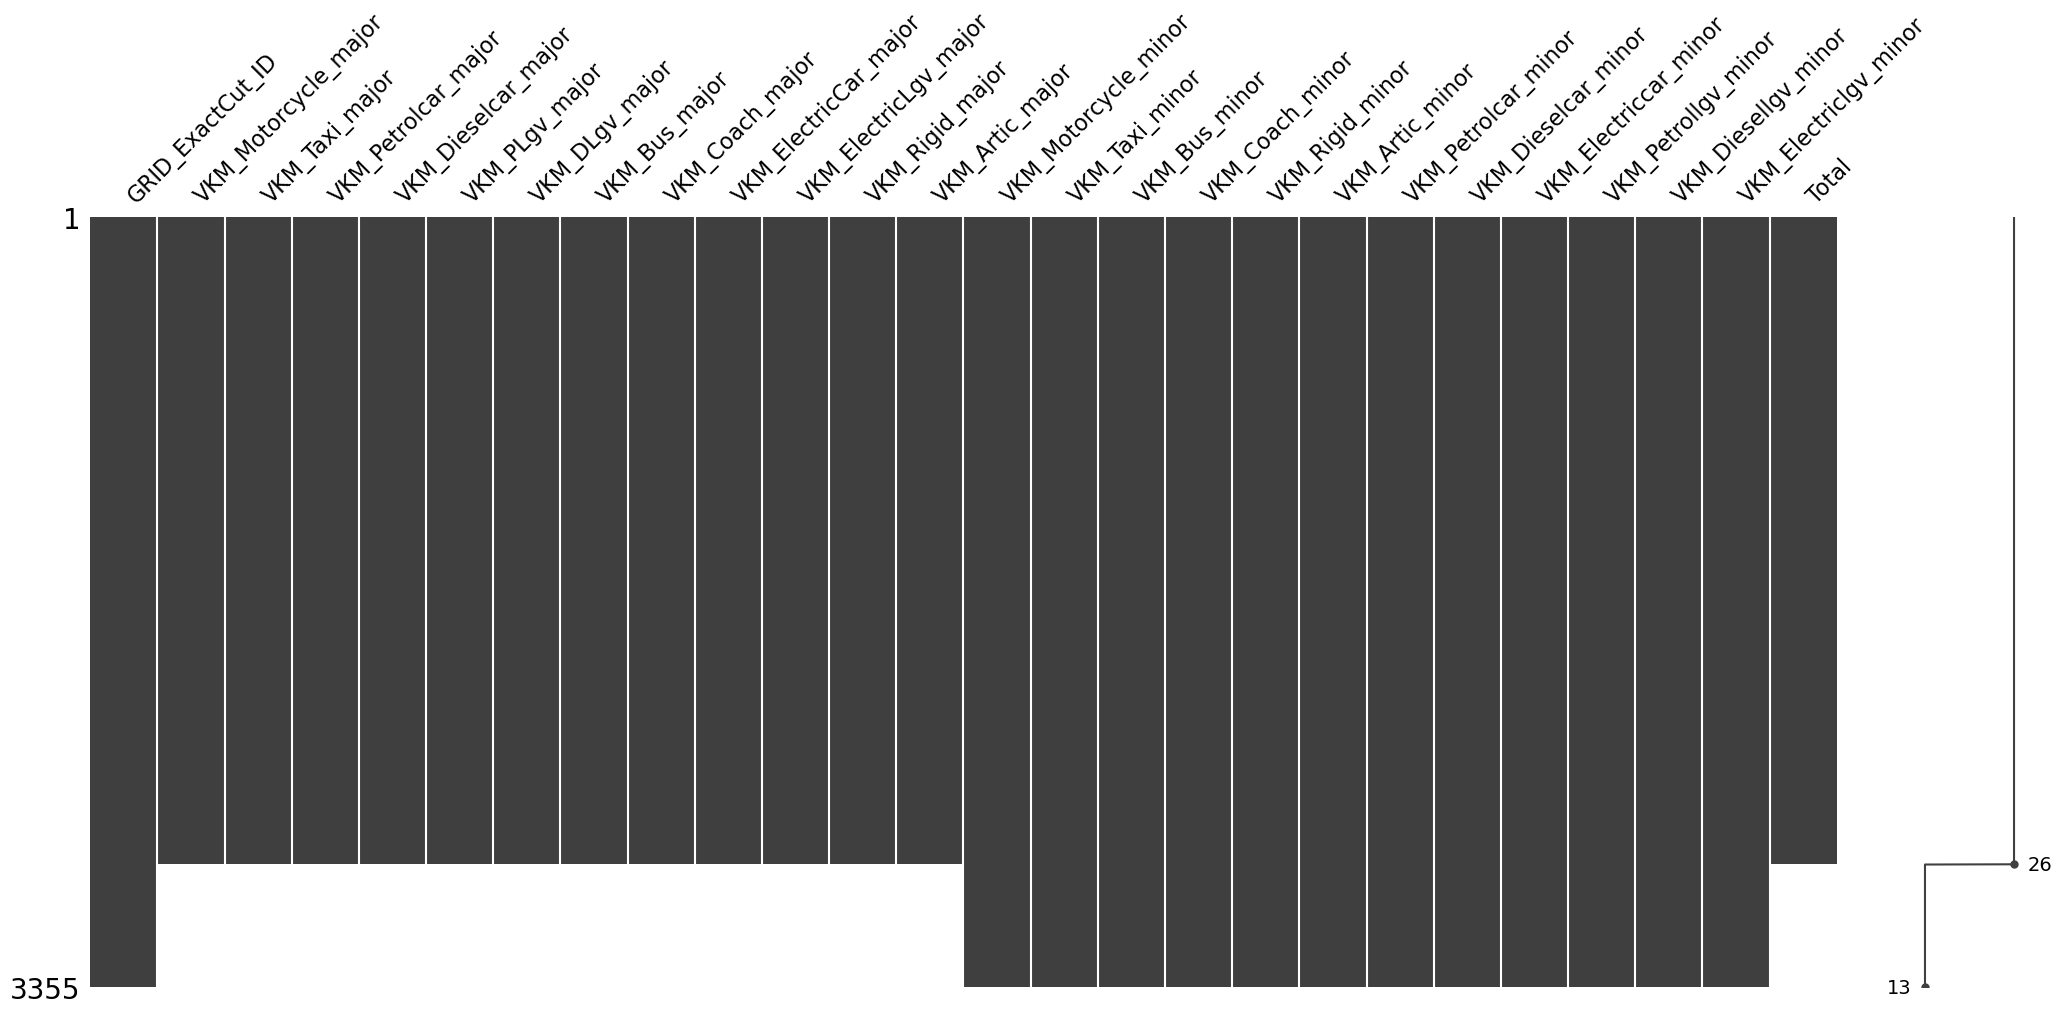

In [646]:
msno.matrix(merged_road_traffic)

In [647]:
# where total is null drop the row

merged_road_traffic.dropna(subset=['Total'], inplace=True)

<Axes: >

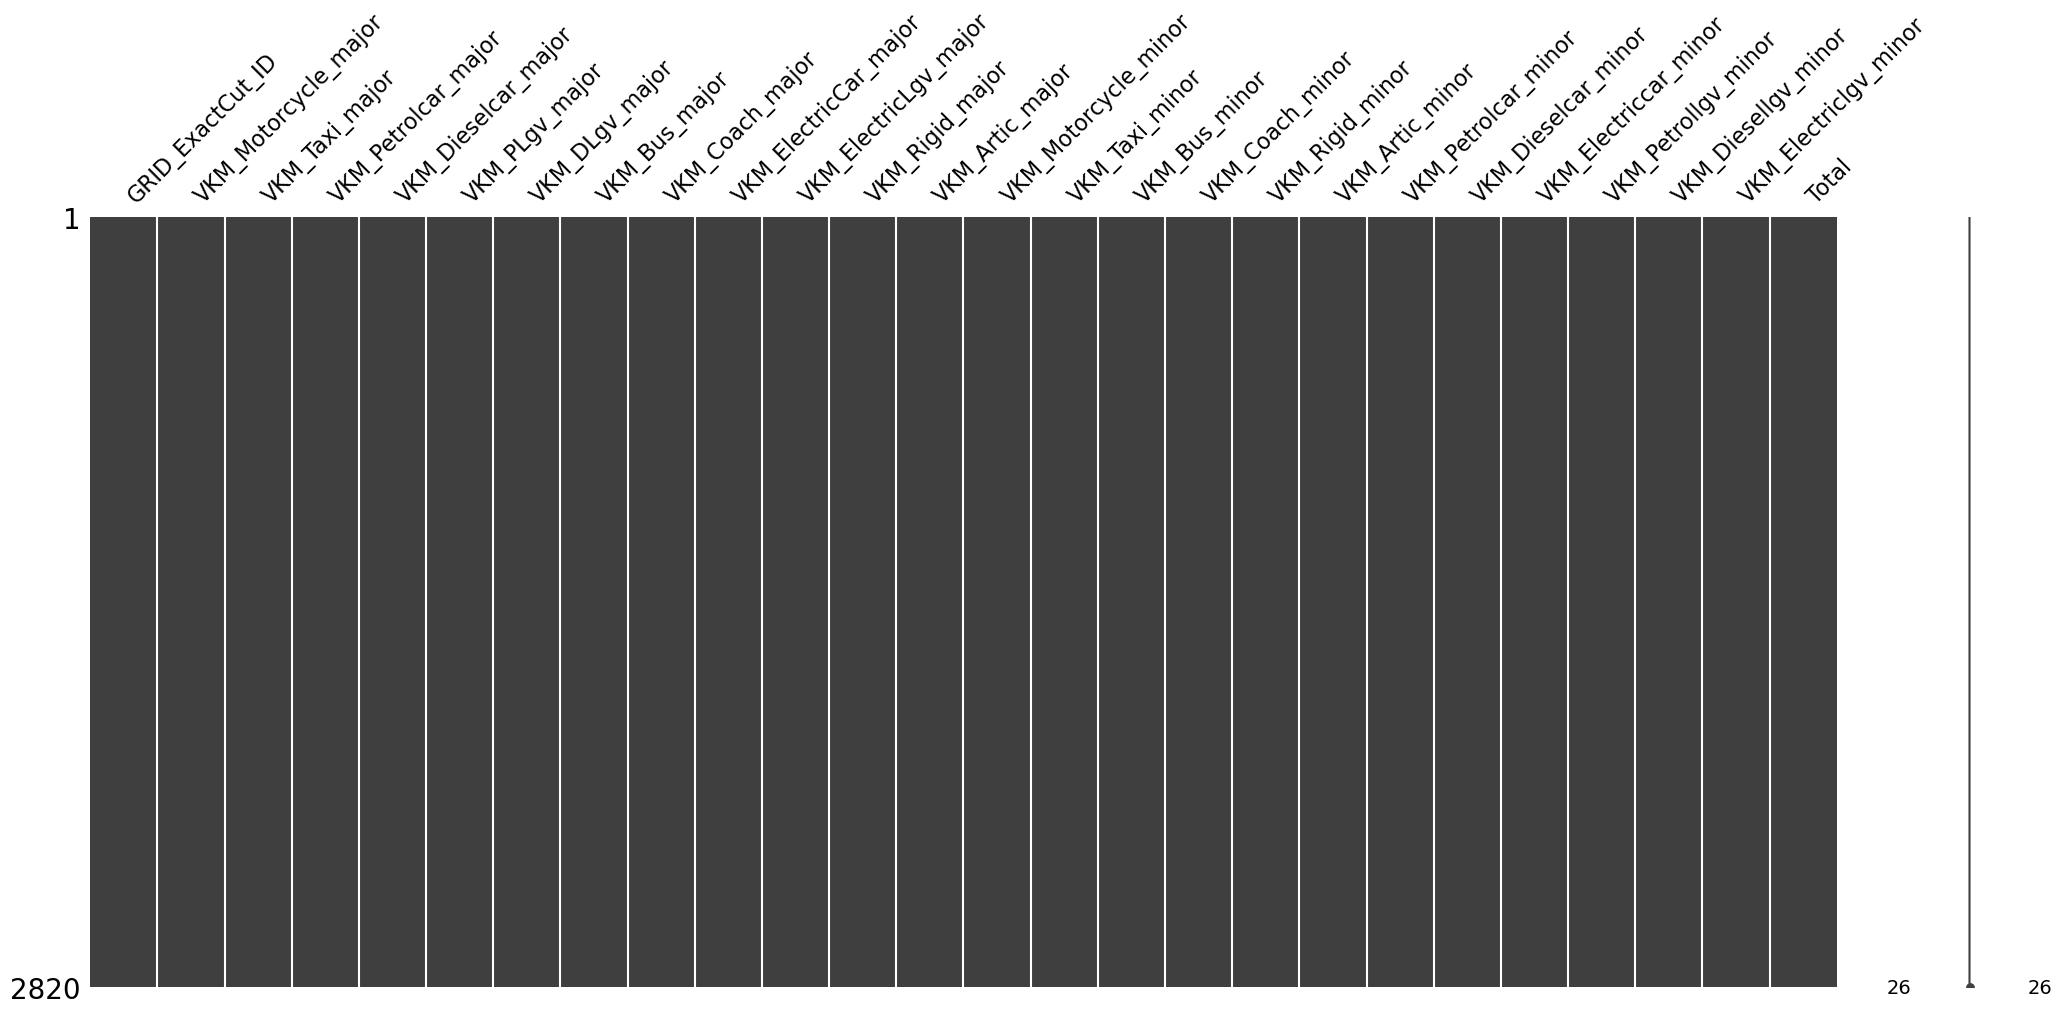

In [648]:
msno.matrix(merged_road_traffic)

In [649]:
merged_road_traffic.duplicated().sum()

0

In [650]:
merged_road_traffic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2820 entries, 0 to 2819
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GRID_ExactCut_ID       2820 non-null   float64
 1   VKM_Motorcycle_major   2820 non-null   float64
 2   VKM_Taxi_major         2820 non-null   float64
 3   VKM_Petrolcar_major    2820 non-null   float64
 4   VKM_Dieselcar_major    2820 non-null   float64
 5   VKM_PLgv_major         2820 non-null   float64
 6   VKM_DLgv_major         2820 non-null   float64
 7   VKM_Bus_major          2820 non-null   float64
 8   VKM_Coach_major        2820 non-null   float64
 9   VKM_ElectricCar_major  2820 non-null   float64
 10  VKM_ElectricLgv_major  2820 non-null   float64
 11  VKM_Rigid_major        2820 non-null   float64
 12  VKM_Artic_major        2820 non-null   float64
 13  VKM_Motorcycle_minor   2820 non-null   float64
 14  VKM_Taxi_minor         2820 non-null   float64
 15  VKM_

In [651]:
merged_road_traffic.head(100)

,GRID_ExactCut_ID,VKM_Motorcycle_major,VKM_Taxi_major,VKM_Petrolcar_major,VKM_Dieselcar_major,VKM_PLgv_major,VKM_DLgv_major,VKM_Bus_major,VKM_Coach_major,VKM_ElectricCar_major,...,VKM_Coach_minor,VKM_Rigid_minor,VKM_Artic_minor,VKM_Petrolcar_minor,VKM_Dieselcar_minor,VKM_Electriccar_minor,VKM_Petrollgv_minor,VKM_Diesellgv_minor,VKM_Electriclgv_minor,Total
0,2.0,319444.228860,332668.490263,2.760651e+07,2.583487e+07,223134.691298,8.287918e+06,133387.356224,227940.774761,5974.926505,...,2962.995481,5041.590112,559.699517,203270.767843,120611.398853,107.778290,711.243897,35736.287198,20.457482,9.751194
1,3.0,86705.716265,155161.422264,1.186193e+07,1.308050e+07,114747.601479,3.894011e+06,14817.305355,87195.481133,753.307705,...,4548.852095,7740.195812,860.663552,312015.145930,185135.244055,165.436767,1091.752757,54854.868005,31.402045,5.455222
2,7.0,100388.899575,167671.175259,1.136762e+07,1.293197e+07,110195.598112,3.673127e+06,0.000000,67310.851847,358.571356,...,12296.970326,20922.256777,2324.881631,843495.530355,500490.930997,447.238462,2951.381308,148291.479929,84.890472,6.262895
3,8.0,148477.032344,221895.635251,1.596811e+07,1.854269e+07,176784.733469,5.845628e+06,0.000000,130616.278550,158.134888,...,3559.524189,6057.278512,672.800520,244196.556929,144894.854478,129.477974,854.438048,42931.044622,24.576170,9.047330
4,9.0,212755.783601,281037.390661,2.074281e+07,2.431121e+07,213873.240120,7.050407e+06,0.000000,164281.001485,0.207283,...,4107.703118,6988.799024,776.257575,281741.318772,167172.166132,149.384969,985.769087,49529.742678,28.353640,8.639122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,113.0,17114.340086,6906.491024,6.290788e+05,3.732660e+05,1870.406064,9.397813e+04,4916.668936,3676.498538,333.550334,...,5751.009708,9784.538813,1086.433947,394473.183762,234062.000199,209.157694,1380.270210,69351.361571,39.700662,0.173180
96,114.0,84254.614089,73296.953428,2.310009e+06,1.370652e+06,10953.492508,5.503557e+05,8738.613732,6534.403888,1224.813759,...,4222.867655,7184.215894,798.331874,289656.728494,171868.801311,153.581880,1013.506965,50923.426042,29.151464,0.584206
97,115.0,125649.083578,95454.290162,5.546039e+06,3.290761e+06,25418.278273,1.277136e+06,42953.633009,32119.097503,2940.622639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.660274
98,116.0,2859.456712,3125.488342,8.788515e+04,5.214695e+04,305.890464,1.536940e+04,0.000000,0.000000,46.598493,...,5946.068122,10117.295774,1123.610029,407861.771338,242006.164003,216.256595,1427.106245,71704.627446,41.047805,0.031677


## Manage Outliers

In [652]:
# Identify outliers using IQR and replace with the median

for column in merged_road_traffic:
    q1 = merged_road_traffic[column].quantile(0.25)
    q3 = merged_road_traffic[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    merged_road_traffic[column] = np.where(merged_road_traffic[column] > upper_bound, merged_road_traffic[column].median(), merged_road_traffic[column])
    merged_road_traffic[column] = np.where(merged_road_traffic[column] < lower_bound, merged_road_traffic[column].median(), merged_road_traffic[column])

## Normalise Data

In [653]:
scaler = MinMaxScaler()

merged_road_traffic_scaled = pd.DataFrame(scaler.fit_transform(merged_road_traffic.iloc[:, 1:]), columns=merged_road_traffic.columns[1:])

In [654]:
merged_road_traffic

,GRID_ExactCut_ID,VKM_Motorcycle_major,VKM_Taxi_major,VKM_Petrolcar_major,VKM_Dieselcar_major,VKM_PLgv_major,VKM_DLgv_major,VKM_Bus_major,VKM_Coach_major,VKM_ElectricCar_major,...,VKM_Coach_minor,VKM_Rigid_minor,VKM_Artic_minor,VKM_Petrolcar_minor,VKM_Dieselcar_minor,VKM_Electriccar_minor,VKM_Petrollgv_minor,VKM_Diesellgv_minor,VKM_Electriclgv_minor,Total
0,2.0,319444.228860,332668.490263,4.349593e+06,2.605911e+06,17387.275615,8.671862e+05,133387.356224,30297.628965,5974.926505,...,2962.995481,5041.590112,559.699517,2.032708e+05,120611.398853,107.778290,711.243897,35736.287198,20.457482,1.830288
1,3.0,86705.716265,155161.422264,1.186193e+07,2.605911e+06,17387.275615,3.894011e+06,14817.305355,87195.481133,753.307705,...,4548.852095,7740.195812,860.663552,3.120151e+05,185135.244055,165.436767,1091.752757,54854.868005,31.402045,5.455222
2,7.0,100388.899575,167671.175259,1.136762e+07,2.605911e+06,17387.275615,3.673127e+06,0.000000,67310.851847,358.571356,...,12296.970326,20922.256777,2324.881631,8.434955e+05,500490.930997,447.238462,2951.381308,148291.479929,84.890472,6.262895
3,8.0,148477.032344,221895.635251,1.596811e+07,2.605911e+06,17387.275615,8.671862e+05,0.000000,130616.278550,158.134888,...,3559.524189,6057.278512,672.800520,2.441966e+05,144894.854478,129.477974,854.438048,42931.044622,24.576170,1.830288
4,9.0,212755.783601,281037.390661,4.349593e+06,2.605911e+06,17387.275615,8.671862e+05,0.000000,164281.001485,0.207283,...,4107.703118,6988.799024,776.257575,2.817413e+05,167172.166132,149.384969,985.769087,49529.742678,28.353640,1.830288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815,3351.0,204985.918592,156249.738708,9.008549e+05,5.345253e+05,8352.526392,4.196708e+05,454768.638773,8832.877200,477.651568,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.159017
2816,3352.0,123703.680681,105503.366513,4.416892e+06,2.620778e+06,55237.636040,2.775402e+06,76853.018430,30297.628965,2341.925905,...,23780.302227,77523.821258,8478.987929,8.268837e+05,490634.229474,438.430518,5907.156571,296803.733155,169.907328,6.579831
2817,3353.0,123703.680681,105503.366513,8.044222e+06,4.773066e+06,76151.078608,3.826194e+06,76853.018430,30297.628965,4265.209796,...,0.000000,19542.828084,2171.349460,1.207141e+06,716261.428310,640.050877,8623.664274,433294.042433,248.042140,1.830288
2818,3354.0,85371.225070,105503.366513,6.873587e+05,4.078466e+05,6580.590643,3.306403e+05,186288.310249,5537.840026,364.451517,...,0.000000,7556.482560,826.523867,8.059953e+04,47824.002716,42.735506,575.791926,28930.533875,16.561482,0.818451


## Data Variance


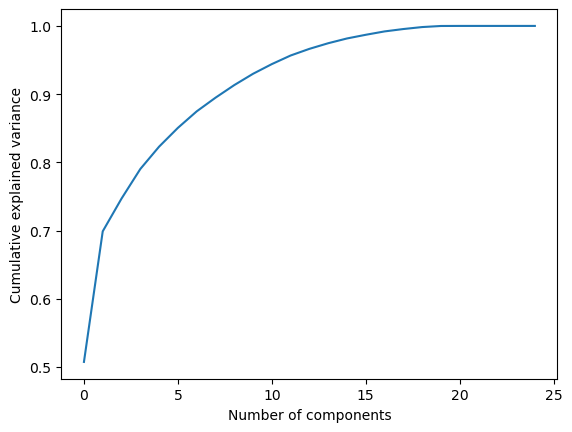

In [655]:
# plot variance explained by each component

pca = PCA().fit(merged_road_traffic_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

## Correlation Analysis

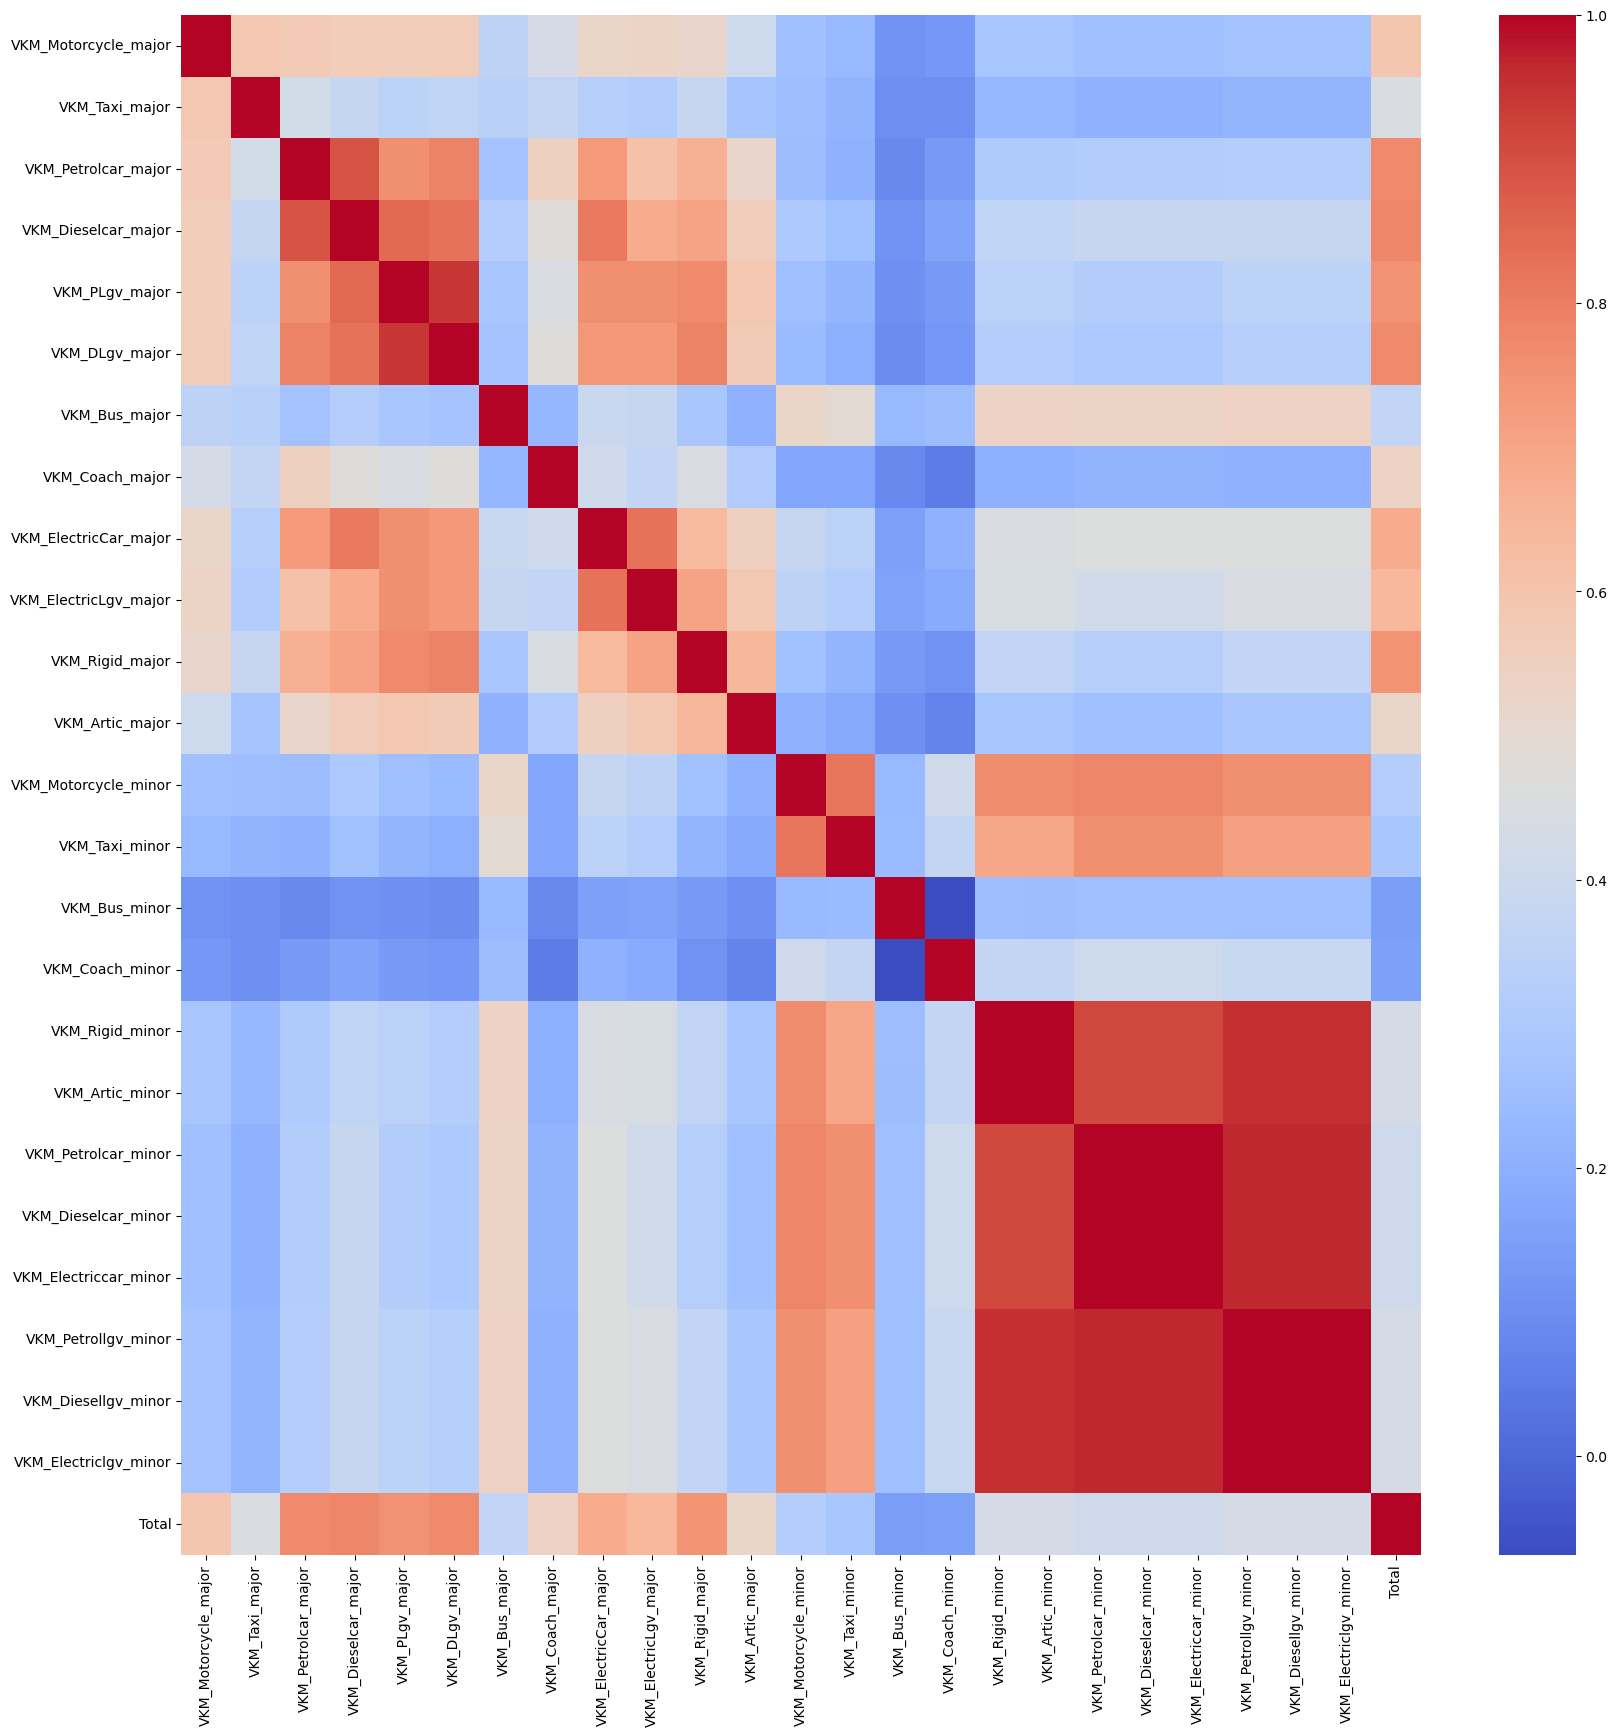

In [656]:
# Correlation dataframe
corr = merged_road_traffic_scaled.corr()

# Plot correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(corr, cmap='coolwarm')
plt.show()

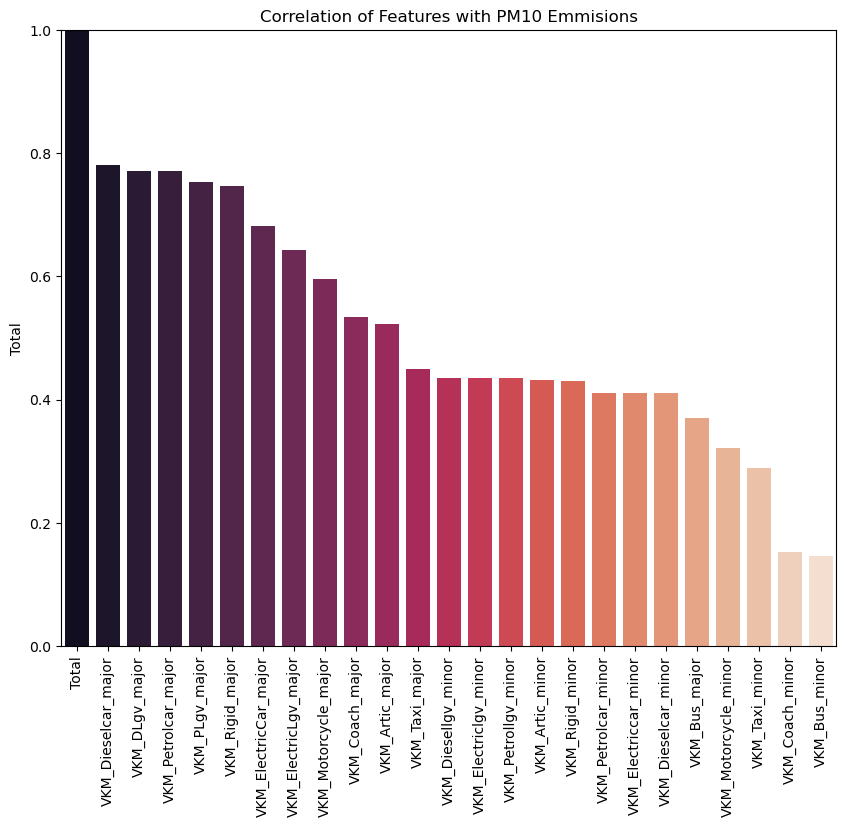

In [657]:
# Create new df showing only the correlations between each feature and the conct feature
corr_conct = pd.DataFrame(corr['Total'])

# Sort the values in descending order
corr_conct.sort_values(by='Total', ascending=False, inplace=True)

# Plot a bar chart of the correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_conct.index, y='Total', data=corr_conct, palette='rocket')
plt.xticks(rotation=90)
plt.title('Correlation of Features with PM10 Emmisions')
plt.ylim(0, 1)
plt.show()

## Export Data

In [658]:
# Export clean_pm10_df in CSV format to the same directory as this notebook
merged_road_traffic_scaled.to_csv('clean_road_traffic_PM10_df.csv', index=False)